Importamos las librerías necesarias

In [227]:
import matplotlib.pyplot as plt
import cornac
import pandas as pd
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF
from sklearn.metrics.pairwise import cosine_similarity
import seaborn

Cargar el dataset de MovieLens 100K

In [228]:
file_path = 'datasets/ml-100k/u.data'
dataframe = pd.read_csv(file_path, sep='|', header=None, encoding='latin-1')
dataset = cornac.datasets.movielens.load_feedback(fmt='UIRT')

file_path = 'datasets/ml-100k/u.item'
movies = pd.read_csv(file_path, sep='|', header=None, encoding='latin-1')

movies.columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movie_genres = movies[genre_columns]
movie_similarities = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {movie_similarities.shape}")

Dimensions of our genres cosine similarity matrix: (1682, 1682)


Exploración de datos

In [229]:
file_path = 'datasets/ml-100k/u.info'
info = pd.read_csv(file_path, sep=' ', header=None, encoding='latin-1')
info.columns = ['data', 'info']
print(info)

     data     info
0     943    users
1    1682    items
2  100000  ratings


In [230]:
sparsity = info['data'][2]/(info['data'][0]*info['data'][1])
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.3%


In [231]:
# Diccionario con las similitudes entre peliculas ordenadas ascendentemente
sim_movies = {}
for idx in range(len(movie_similarities)):
    sim_scores = list(enumerate(movie_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1])
    sim_movies[idx] = sim_scores

Crear modelos propios

In [232]:
class Hybrid(cornac.models.Recommender):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(name=name)
        self.models = models
        self.weights = weights

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        for m in self.models:
            m.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None):
        ponderated_sum = 0
        # if each weight is 1/len(weights)then the score is the average  
        for idx in range(len(self.models)):
            ponderated_sum += self.models[idx].score(user_idx, item_idx)*self.weights[idx]

        return ponderated_sum/sum(self.weights)

class DHybrid(Hybrid):
    def __init__(self, models, weights, name="Hybrid", flag=False):
        super().__init__(models, weights, name)
        self.flag = flag
        
    def fit(self, train_set, eval_set=None):
        super().fit(train_set, eval_set)
        
    def score(self, user_idx, item_idx=None):
        return super().score(user_idx, item_idx)
    
    def recommend(self, user_id, k=-1, remove_seen=False, train_set=None, n=3):
        recommendations = super().recommend(user_id, k, remove_seen, train_set)
        if self.flag:
            sim_scores = sim_movies[int(recommendations[0])]
            similar_movies = [i[0] for i in sim_scores[:n]]
            recommendations = recommendations + similar_movies
        return recommendations
    

Definir el método de evaluación

In [233]:
ratio_split = RatioSplit(data=dataset, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1644
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1644
Number of ratings = 19952
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1644


Definir los modelos a emplear

In [234]:

mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = DHybrid([svd, bpr, knn], (10,3,1), flag=True)

models = [mf, bpr, svd, knn, hybrid]

Definir las metricas a utilizar

In [235]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento


In [236]:
experiment = cornac.Experiment(eval_method=ratio_split, models=models, metrics=metrics)

Ejecutar el experimento

In [237]:
experiment.run()


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1644 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[Hybrid] Training started!


  0%|          | 0/1644 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19952 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
        |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------------ + --------- + --------- + --------
MF      | 0.7456 | 0.9038 |       0.0723 |    0.0521 |    0.0999 |   0.9625
BPR     | 2.1731 | 2.3719 |       0.1057 |    0.1090 |    0.0804 |   0.9389
SVD     | 0.7559 | 0.9140 |       0.0567 |    0.0425 |    0.0431 |   1.0208
ItemKNN | 0.8166 | 0.9869 |       0.0266 |    0.0149 |    0.1147 |   7.1730
Hybrid  | 0.8819 | 1.0398 |       0.1344 |    0.1093 |    0.3989 |   6.5068



Extraer los resultados de las métricas

In [238]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

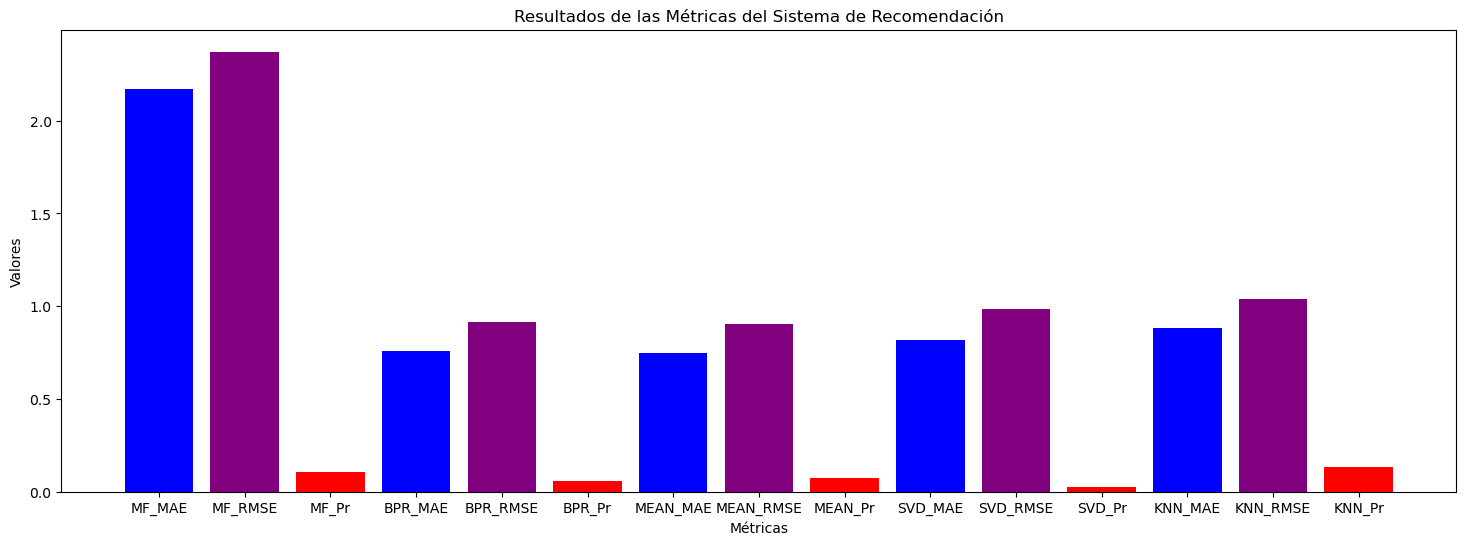

In [239]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()


### Diversity Metrics ###

In [240]:
def intra_list_diversity(recommendation_list, similarity_matrix):
    """
    Calculate the intra-list diversity of a recommendation list.
    
    Parameters:
    recommendation_list (list): List of recommended item indices.
    similarity_matrix (numpy.ndarray): Precomputed similarity matrix where element (i, j) represents the similarity between item i and item j.
    
    Returns:
    float: Intra-list diversity score.
    """
    n = len(recommendation_list)
    if n <= 1:
        return 0.0
    
    total_dissimilarity = 0.0
    count = 0
    
    for i in range(n):
        for j in range(i + 1, n):
            total_dissimilarity += 1 - similarity_matrix[recommendation_list[i]-1][recommendation_list[j]-1]
            count += 1
    
    return total_dissimilarity / count

In [241]:

for model in models:
    t_diversity_score = 0
    for user_id in range(1, model.total_users):
        recs = [int(i) for i in model.recommend(user_id=str(user_id), k=20)]
        t_diversity_score += intra_list_diversity(recs, movie_similarities)
        
    avg = t_diversity_score/info['data'][0]
    print(f"Intra-list diversity score average of model {model.name}: {avg}")

Intra-list diversity score average of model MF: 0.7289722224638678
Intra-list diversity score average of model BPR: 0.7128992573789954
Intra-list diversity score average of model SVD: 0.7069958236822249
Intra-list diversity score average of model ItemKNN: 0.7215197391997275
Intra-list diversity score average of model Hybrid: 0.6875849112226295
